In [1]:
import sys

# # !{sys.executable} -m pip install torch
# # !{sys.executable} -m pip install torchvision
# !{sys.executable} -m pip install transformers
# !{sys.executable} -m pip install -q datasets jiwer
# !{sys.executable} -m pip install ipywidgets widgetsnbextension pandas-profiling

In [2]:
# Melihat GPU yang tersedia dan penggunaannya.
!nvidia-smi --query-gpu=index,memory.used,memory.total,memory.free,utilization.gpu --format=csv,noheader | awk -F "," 'BEGIN{printf "%-3s \t%7s\t%5s\t%12s\n", "GPU", "Memory", "Free", "RAM"}{printf "%s:\t%6.2f%%\t%7s\t%s\n", $1, ($2/$3)*100, $4, $5}'

GPU 	 Memory	 Free	         RAM
0:	 77.61%	 9076 MiB	 28 %
1:	 70.72%	 11871 MiB	 13 %
2:	 96.43%	 1449 MiB	 0 %
3:	 92.15%	 3182 MiB	 100 %
4:	 85.42%	 5911 MiB	 100 %
5:	 99.99%	  5 MiB	 0 %
6:	  3.54%	 39101 MiB	 21 %
7:	 72.01%	 11346 MiB	 98 %


In [3]:
# Memilih GPU yang akan digunakan (contohnya: GPU #7)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
from PIL import Image
from IPython.display import display
import numpy as np
import importlib

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

from PIL import Image

import json
import os
import glob
import re
import datetime
import shutil
import pickle
import unicodedata

from functools import partial

from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import random

import matplotlib.pyplot as plt

import sys
sys.path.append('../..')
import importlib
import pegon_utils
importlib.reload(pegon_utils)
from pegon_utils import PEGON_CHARS, CHAR_MAP

seed = 2023
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [6]:
model_name = 'trocr'
os.makedirs(model_name, exist_ok=True)

In [7]:
from tqdm import tqdm
import json
import shutil
import random
import datetime
import pickle

class OCRDataset(Dataset):
    
    def __init__(self, transform=None, processor=None, char_map=CHAR_MAP, img_format='png',
                 target_dir='tmp', max_seq_len=0, files_and_labels=[],
                 avg_img_w=0, avg_img_h=0, avg_seq_len=0,
                 blank_idx=0, unknown_idx=-1):
        self.img_format = img_format
        self.target_dir = target_dir
        self.files_and_labels = files_and_labels
        
        self.char_map = char_map
        self.blank_char = list(self.char_map.keys())[blank_idx]
        self.unknown_char = list(self.char_map.keys())[unknown_idx]
        self.blank_idx = self.char_map[self.blank_char]
        self.unknown_idx = self.char_map[self.unknown_char]
        
        self.max_seq_len = max_seq_len
        self.files_and_labels = files_and_labels
        self.avg_seq_len = avg_seq_len
        self.avg_img_w = avg_img_w
        self.avg_img_h = avg_img_h
        
        self.transform = transform
        self.processor = processor
    
    def read_directory(self, file_dir,
                       force_rewrite=False,
                       skip_duplicates=False,
                       in_img_format='png',
                       sample=1):
        if force_rewrite:
            self.files_and_labels = []
        total_seq_len = 0
        total_img_h = 0
        total_img_w = 0
        
        if os.path.exists(self.target_dir):
            if not force_rewrite:
                raise FileExistsError(f'{self.target_dir} already exists and force rewrite not allowed')
            else:
                shutil.rmtree(self.target_dir)

        os.makedirs(self.target_dir)
        
        files = glob.glob(os.path.join(file_dir, f"**/*.{in_img_format}"), recursive=True)
        
        for fullpath in tqdm(random.sample(files, int(len(files) * sample))):

            with open(re.sub(f'.{in_img_format}$', '.json', fullpath), 'r') as f:
                bbox_list = json.load(f)
            with Image.open(fullpath) as image:
                for idx, obj in enumerate(bbox_list):
                    label = obj['text']
                    seq_len = len(label)
                    left, top, right, bottom = obj['bbox']
                    if (right - left) * (bottom - top) == 0:
                        label = obj['text']
                        print(f"Skipping empty bbox ({left}, {top}, {right}, {bottom}) and label {label}")
                        continue

                    cropped_image = image.crop(obj['bbox'])
                    target_timestamp = str(datetime.datetime.now().timestamp())
                    target_filepath = os.path.join(self.target_dir, f'{target_timestamp}.{self.img_format}')
                    cropped_image.save(target_filepath)
            
                    self.files_and_labels.append((target_timestamp, label))
                
                    self.max_seq_len = max(seq_len, self.max_seq_len)
                    total_seq_len += seq_len
                    total_img_h += bottom - top
                    total_img_w += right - left

        self.avg_seq_len = int(total_seq_len / len(self.files_and_labels))
        self.avg_img_w = int(total_img_w / len(self.files_and_labels))
        self.avg_img_h = int(total_img_h / len(self.files_and_labels))
    
    
    def save(self, filename='metadata.json'):
        # Create a dictionary with all JSON-serializable attributes
        data = {}
        for attr in dir(self):
            if not attr.startswith("__"):
                try:
                    json.dumps(getattr(self, attr))
                    data[attr] = getattr(self, attr)
                except TypeError:
                    pass
        # Write the dictionary to a JSON file
        with open(os.path.join(self.target_dir, filename), 'w') as outfile:
            json.dump(data, outfile)

    @classmethod
    def load_static(cls, filename):
        self = object.__new__(cls)
        self.__class__ = cls
        with open(filename) as infile:
            data = json.load(infile)
        # Set the selected attributes in the object
        for attr, value in data.items():
            setattr(self, attr, value)
        return self
    
    def load(self, filename):
        with open(filename) as infile:
            data = json.load(infile)
        # Set the selected attributes in the object
        for attr, value in data.items():
            setattr(self, attr, value)
        return self
    
    def __len__(self):
        return len(self.files_and_labels)
    
    def to_class(self, char):
        try:
            return self.char_map[char]
        except KeyError:
            return self.char_map[self.unknown_char]

    def char_segment(self, label):
        # later this can be fine-tuned to only split characters and not harakat
        return list(label)

    def __getitem__(self, idx):
        image_timestamp, label = self.files_and_labels[idx]
        image_path = os.path.join(self.target_dir, f'{image_timestamp}.{self.img_format}')
        cropped_image = self.transform(Image.open(image_path).convert('RGB'))
        label = ''.join(list(filter(lambda c:unicodedata.category(c)[0] != 'C',
                                               label)))
        
        pixel_values = self.processor(cropped_image, return_tensors="pt").pixel_values
#         add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(label, 
                                          padding="max_length", 
                                          max_length=self.max_seq_len).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [8]:
from torch.utils.data import random_split

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-str")
# feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-384")
# decoder_tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")
# processor =TrOCRProcessor(feature_extractor=feature_extractor, tokenizer=decoder_tokenizer)

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-384", "aubmindlab/bert-base-arabertv02")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of the model checkpoint at google/vit-base-patch16-384 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02 were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing B

In [9]:
importlib.reload(pegon_utils)
from pegon_utils import QuranAnnotatedDataset
from torch.utils.data import random_split, ConcatDataset

dataset_transforms = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
    transforms.Resize((pegon_synth_dataset.avg_img_h,
                       pegon_synth_dataset.avg_img_w)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

pegon_synth_dataset = OCRDataset(transform=dataset_transforms, processor=processor, char_map=CHAR_MAP).load('/workspace/Dataset/Synthesized-split/metadata.json')
train_dataset, val_dataset = random_split(pegon_synth_dataset,
                                                      lengths=[round(len(pegon_synth_dataset) * frac) for frac in [0.7, 0.3]])


# quran_train_dataset = QuranAnnotatedDataset('/workspace/Dataset/Quran data set/dicriticText/traning',
#                       image_transform=dataset_transforms)
# quran_test_dataset = QuranAnnotatedDataset('/workspace/Dataset/Quran data set/dicriticText/test',
#                       image_transform=dataset_transforms)

# train_dataset = ConcatDataset((train_synth_dataset, quran_train_dataset))
# val_dataset = ConcatDataset((val_synth_dataset, quran_test_dataset))

NameError: name 'pegon_synth_dataset' is not defined

In [ ]:
encoding = val_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

In [14]:
import torch.nn as nn

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.encoder.embeddings.dropout = nn.Dropout(0.1)
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = pegon_synth_dataset.max_seq_len
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [15]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import transformers as tr

training_args = tr.Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    dataloader_num_workers=2,
    fp16=True, 
    output_dir="./trocr",
    logging_steps=2,
    save_steps=20000,
    eval_steps=20000,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
from datasets import load_metric

cer_metric = load_metric("cer")

/tmp/ipykernel_2398/152175726.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [17]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [18]:
def collate_fn(batch):
        max_len = 209
        # Sort the batch by sequence length (in descending order)
        batch = sorted(batch, key=lambda x: x['pixel_values'].shape[2], reverse=True)

        # Extract the image tensors and label lists from the sorted batch
        images = [item['pixel_values'] for item in batch]
        labels = [item['labels'] for item in batch]
        label_lengths = torch.LongTensor([len(label) for label in labels])
        # Pad the label lists with the blank token
        labels = [label[:max_len] + torch.Tensor([-100]) * (max_len-len(label[:max_len])) for label in labels]

        # Stack the image tensors into a single tensor
        images = torch.stack(images, dim=0)

        # convert the float tensors to integer tensors by rounding
        labels = [torch.round(l) for l in labels]

        # convert the list of integer tensors to a LongTensor
        labels = torch.stack(labels).long()

        return {"pixel_values":images, "labels":labels}

In [19]:
from transformers import default_data_collator

# instantiate trainer
trainer = tr.Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
)

/opt/conda/lib/python3.8/site-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [20]:
timestamp = datetime.datetime.now()
print(timestamp)

2023-06-01 16:59:22.173262


In [21]:
trainer.train()
trainer.save_model('./trainedModels/TrOCR_Arabert_with_synthesized-2')

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss,Cer
20000,1.192100,0.875304,0.942455
40000,0.797000,0.803678,0.830121


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

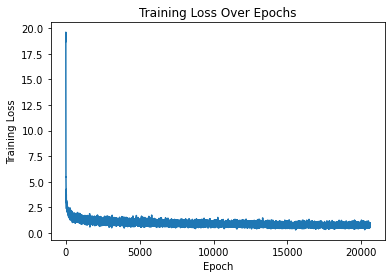

In [45]:
import matplotlib.pyplot as plt

# Assuming you have a `trainer` object of Seq2SeqTrainer

# Access the training logs
logs = trainer.state.log_history
training_loss = [log['loss'] for log in logs if 'loss' in log]

# Create a plot
plt.plot(training_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [72]:
import unicodedata, glob, os, re
from torch.utils.data import Dataset
from torchvision.transforms import transforms
from PIL import Image

class AnnotatedDataset(Dataset):
    tokens_to_ignore = []
    tokens_to_unknown = []

    translation_table = str.maketrans('', '')
    
    def __init__(self, directory, processor=None, image_transform=transforms.ToTensor(),
                 blank_idx=0, unknown_idx=-1,
                 filetypes=['png'], char_map=CHAR_MAP):
        self.directory = directory
        self.files = sum((glob.glob(os.path.join(directory, f'*.{filetype}')) for filetype in filetypes), [])
        self.processor = processor
        self.image_transform = image_transform
        self.char_map = char_map
        self.blank_char = list(self.char_map.keys())[blank_idx]
        self.unknown_char = list(self.char_map.keys())[unknown_idx]
        self.blank_idx = self.char_map[self.blank_char]
        self.unknown_idx = self.char_map[self.unknown_char]
        self.max_seq_len = 123
        
        if len(self.__class__.tokens_to_ignore) == 0:
            self.__class__.ignore_pattern = r'$^'
        else:
            self.__class__.ignore_pattern = "|".join(map(re.escape, self.__class__.tokens_to_ignore))
        if len(self.__class__.tokens_to_unknown) == 0:
            self.__class__.unknown_pattern = r'$^'
        else:
            self.__class__.unknown_pattern = "|".join(map(re.escape, self.__class__.tokens_to_unknown))
    
    def filename_to_label(self, filename):
        return filename
    def to_class(self, char):
        try:
            return self.char_map[char]
        except KeyError:
            return self.char_map[self.unknown_char]

    def char_segment(self, label):
        return list(label)
    
    def label_transform(self, label):
        label = self.filename_to_label(label)
        label = re.sub(self.__class__.unknown_pattern, self.unknown_char, label)
        label = re.sub(self.__class__.ignore_pattern, '', label)
        label = label.translate(self.__class__.translation_table)
        
#         label = [self.to_class(c) for c in filter(lambda c:unicodedata.category(c)[0] != 'C',
#                                                   f'-{"-".join(self.char_segment(label))}-')]
        label = list(map(self.to_class, filter(lambda c:unicodedata.category(c)[0] != 'C', label)))
        return label

    def __getitem__(self, idx):      
        path = self.files[idx]
        img = self.image_transform(Image.open(path).convert('RGB'))
        pixel_values = self.processor(img, return_tensors="pt").pixel_values
        
        label = os.path.basename(path[:path.rfind('.')]).split(';')[0]
        labels = self.processor.tokenizer(label, 
                                          padding="max_length", 
                                          max_length=self.max_seq_len).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding
    
    
    def __len__(self):
        return len(self.files)

class PegonAnnotatedDataset(AnnotatedDataset):
    tokens_to_unknown = ['[CALLIGRAPHY]',
                        '[NASTALIQ]',
                        '[UNKNOWN]',
                        '[VERT]']
    
    tokens_to_ignore = ['‌']

    translation_table = str.maketrans('1234567890', '١٢٣٤٥٦٧٨٩٠')
    
    def filename_to_label(self, filename):
        return filename.split(';')[0]

In [89]:
annotated_dataset = PegonAnnotatedDataset('/workspace/Dataset/pegon-annotated-dataset-split-v3',
                                          image_transform=dataset_transforms, processor=processor)

ann_synth = trainer.evaluate(annotated_dataset)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
# import os, signal

# os.kill(os.getpid(), signal.SIGKILL)